In [5]:

# !pip install wandb torch torchvision --quiet
import os, random, shutil
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from datetime import datetime
from PIL import Image


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

!unzip -q /content/drive/MyDrive/nature_12K.zip -d /content


In [7]:
DATA_DIR = "/content/inaturalist_12K"

In [8]:

def split_manual(data_dir, val_ratio=0.2, seed=42):
    train_dir = os.path.join(data_dir, "train")
    full_dataset = datasets.ImageFolder(train_dir)

    class_indices = defaultdict(list)
    for idx, label in enumerate(full_dataset.targets):
        class_indices[label].append(idx)

    train_indices, val_indices = [], []
    random.seed(seed)
    for label, indices in class_indices.items():
        random.shuffle(indices)
        val_size = int(len(indices) * val_ratio)
        val_indices.extend(indices[:val_size])
        train_indices.extend(indices[val_size:])

    train_subset = Subset(full_dataset, train_indices)
    val_subset = Subset(full_dataset, val_indices)
    return train_subset, val_subset, full_dataset.classes

train_set, val_set, classes = split_manual(DATA_DIR)
NUM_CLASSES = len(classes)
print(f"Train/Val Split: {len(train_set)} / {len(val_set)} | Classes: {NUM_CLASSES}")


Train/Val Split: 8000 / 1999 | Classes: 10


In [9]:

def get_transforms(augment=False):
    if augment:
        return transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])


In [23]:

class CNNModel(nn.Module):
    def __init__(self, num_classes, filters=32, filter_policy='same', activation='ReLU',
                 batch_norm=False, dropout=0.0):
        super(CNNModel, self).__init__()

        activations = {
            'ReLU': nn.ReLU,
            'GELU': nn.GELU,
            'SiLU': nn.SiLU,
            'Mish': nn.Mish
        }
        act_fn = activations[activation]

        layers = []
        in_channels = 3
        current_filters = filters
        self.final_filters = current_filters

        for i in range(5):
            layers.append(nn.Conv2d(in_channels, current_filters, kernel_size=3, padding=1))
            if batch_norm:
                layers.append(nn.BatchNorm2d(current_filters))
            layers.append(act_fn())
            layers.append(nn.MaxPool2d(2))
            if dropout > 0:
                layers.append(nn.Dropout2d(p=dropout))
            in_channels = current_filters

            if filter_policy == 'double':
                current_filters *= 2
            elif filter_policy == 'half' and current_filters > 1:
                current_filters = max(4, current_filters // 2) #current_filters //= 2

        self.final_filters = in_channels
        self.conv = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.final_filters, 128),
            act_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [24]:

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [25]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc = correct / total
    return val_loss, val_acc

In [26]:

def sweep_train():
    wandb.init()
    config = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNModel(num_classes=NUM_CLASSES,
                     filters=config.filters,
                     filter_policy=config.filter_policy,
                     activation=config.activation,
                     batch_norm=config.batch_norm,
                     dropout=config.dropout).to(device)

    transform_train = get_transforms(config.augmentation)
    transform_val = get_transforms(False)

    train_set.dataset.transform = transform_train
    val_set.dataset.transform = transform_val

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    for epoch in range(5):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Save model if best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "model.pth")
            wandb.save("model.pth")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })


In [ ]:

def sweep_train():
    wandb.init()
    config = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNModel(num_classes=NUM_CLASSES,
                     filters=config.filters,
                     filter_policy=config.filter_policy,
                     activation=config.activation,
                     batch_norm=config.batch_norm,
                     dropout=config.dropout).to(device)

    transform_train = get_transforms(config.augmentation)
    transform_val = get_transforms(False)

    train_set.dataset.transform = transform_train
    val_set.dataset.transform = transform_val

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(5):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })


In [28]:

sweep_config = {
    "method": "random",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "filters": {"values": [32, 64]},
        "filter_policy": {"values": ["same", "double", "half"]},
        "activation": {"values": ["ReLU", "GELU", "SiLU", "Mish"]},
        "batch_norm": {"values": [True, False]},
        "dropout": {"values": [0.2, 0.3]},
        "augmentation": {"values": [True, False]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="inat-cnn-sweep")
wandb.agent(sweep_id, function=sweep_train, count=20)


Create sweep with ID: 410m5q2c
Sweep URL: https://wandb.ai/alokgaurav04-indian-institute-of-technology-madras/inat-cnn-sweep/sweeps/410m5q2c


wandb: Agent Starting Run: pkrk7i6q with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_norm: False
wandb: 	dropout: 0.3
wandb: 	filter_policy: same
wandb: 	filters: 32


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▄▂▁▁
val_acc,▁▃▆█▇
val_loss,█▆▃▁▁
epoch,5
train_acc,0.2
train_loss,2.15668
val_acc,0.21011
val_loss,2.13001


wandb: Agent Starting Run: ikqjb6bb with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_norm: True
wandb: 	dropout: 0.3
wandb: 	filter_policy: double
wandb: 	filters: 32


epoch,▁▃▅▆█
train_acc,▁▆▇▇█
train_loss,█▄▂▁▁
val_acc,▂▇█▁▃
val_loss,▇▃▁█▃
epoch,5
train_acc,0.23875
train_loss,2.11042
val_acc,0.23062
val_loss,2.09635


wandb: Agent Starting Run: xtn8gdtj with config:
wandb: 	activation: ReLU
wandb: 	augmentation: False
wandb: 	batch_norm: False
wandb: 	dropout: 0.2
wandb: 	filter_policy: same
wandb: 	filters: 32


epoch,▁▃▅▆█
train_acc,▁▄▆██
train_loss,█▅▄▂▁
val_acc,▁▄▇█▆
val_loss,█▆▄▁▃
epoch,5
train_acc,0.1835
train_loss,2.18968
val_acc,0.18809
val_loss,2.2076


wandb: Agent Starting Run: j9ewafq0 with config:
wandb: 	activation: ReLU
wandb: 	augmentation: True
wandb: 	batch_norm: True
wandb: 	dropout: 0.3
wandb: 	filter_policy: same
wandb: 	filters: 32


epoch,▁▃▅▆█
train_acc,▁▅▆██
train_loss,█▃▂▁▁
val_acc,▃▃▁█▇
val_loss,█▅▅▂▁
epoch,5
train_acc,0.19162
train_loss,2.18078
val_acc,0.21961
val_loss,2.13973


wandb: Agent Starting Run: 73gw5kfr with config:
wandb: 	activation: Mish
wandb: 	augmentation: False
wandb: 	batch_norm: False
wandb: 	dropout: 0.3
wandb: 	filter_policy: half
wandb: 	filters: 64


epoch,▁▃▅▆█
train_acc,▁▆███
train_loss,█▄▂▁▁
val_acc,▁▆▆█▆
val_loss,█▅▂▁▁
epoch,5
train_acc,0.1515
train_loss,2.23301
val_acc,0.16308
val_loss,2.21015


wandb: Agent Starting Run: 6h0r51rw with config:
wandb: 	activation: ReLU
wandb: 	augmentation: True
wandb: 	batch_norm: True
wandb: 	dropout: 0.2
wandb: 	filter_policy: double
wandb: 	filters: 64


epoch,▁▃▅▆█
train_acc,▁▅▇▇█
train_loss,█▄▂▂▁
val_acc,▁▃█▅▇
val_loss,█▅▁▂▁
epoch,5
train_acc,0.24063
train_loss,2.08866
val_acc,0.26363
val_loss,2.0522


wandb: Agent Starting Run: j367lzvq with config:
wandb: 	activation: GELU
wandb: 	augmentation: False
wandb: 	batch_norm: False
wandb: 	dropout: 0.3
wandb: 	filter_policy: double
wandb: 	filters: 32


epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁██▇▄
val_loss,█▂▁▂▆
epoch,5
train_acc,0.2035
train_loss,2.17345
val_acc,0.18409
val_loss,2.18503


wandb: Agent Starting Run: w8vulkre with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_norm: True
wandb: 	dropout: 0.2
wandb: 	filter_policy: half
wandb: 	filters: 32


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▄▂▂▁
val_acc,▇▁▆██
val_loss,▆█▂▁▁
epoch,5
train_acc,0.17475
train_loss,2.19228
val_acc,0.2051
val_loss,2.15409


wandb: Agent Starting Run: knp3w3gd with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_norm: True
wandb: 	dropout: 0.3
wandb: 	filter_policy: double
wandb: 	filters: 32


epoch,▁▃▅▆█
train_acc,▁▆▇▇█
train_loss,█▄▃▂▁
val_acc,▁▂█▆█
val_loss,█▅▄▃▁
epoch,5
train_acc,0.23538
train_loss,2.10273
val_acc,0.26013
val_loss,2.0582


wandb: Agent Starting Run: 3ugnu8lr with config:
wandb: 	activation: ReLU
wandb: 	augmentation: False
wandb: 	batch_norm: True
wandb: 	dropout: 0.2
wandb: 	filter_policy: same
wandb: 	filters: 64


epoch,▁▃▅▆█
train_acc,▁▅▇██
train_loss,█▄▃▂▁
val_acc,▁▁▅█▄
val_loss,██▁▁▂
epoch,5
train_acc,0.23888
train_loss,2.09754
val_acc,0.25063
val_loss,2.06653


wandb: Agent Starting Run: rywevqtj with config:
wandb: 	activation: SiLU
wandb: 	augmentation: True
wandb: 	batch_norm: True
wandb: 	dropout: 0.2
wandb: 	filter_policy: half
wandb: 	filters: 64


epoch,▁▃▅▆█
train_acc,▁▇▇▇█
train_loss,█▄▃▂▁
val_acc,▁▁▅▇█
val_loss,█▆▅▃▁
epoch,5
train_acc,0.18363
train_loss,2.17258
val_acc,0.22311
val_loss,2.12326


wandb: Agent Starting Run: b716tt5d with config:
wandb: 	activation: SiLU
wandb: 	augmentation: True
wandb: 	batch_norm: False
wandb: 	dropout: 0.3
wandb: 	filter_policy: double
wandb: 	filters: 32


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▃▁▁
val_acc,▁▇█▇█
val_loss,█▃▃▁▁
epoch,5
train_acc,0.2105
train_loss,2.16118
val_acc,0.22261
val_loss,2.12376


wandb: Agent Starting Run: tbc8da4l with config:
wandb: 	activation: ReLU
wandb: 	augmentation: True
wandb: 	batch_norm: False
wandb: 	dropout: 0.3
wandb: 	filter_policy: half
wandb: 	filters: 32


epoch,▁▃▅▆█
train_acc,▁▂▃▅█
train_loss,██▆▄▁
val_acc,▁▁▄██
val_loss,██▅▁▁
epoch,5
train_acc,0.13325
train_loss,2.27975
val_acc,0.15058
val_loss,2.26196


wandb: Agent Starting Run: pz9qn6h3 with config:
wandb: 	activation: SiLU
wandb: 	augmentation: True
wandb: 	batch_norm: False
wandb: 	dropout: 0.3
wandb: 	filter_policy: double
wandb: 	filters: 32


wandb: Ctrl + C detected. Stopping sweep.


In [35]:

# 1. Load best run manually from W&B dashboard or set run ID here
# Replace with your actual best run ID from the sweep
best_run_id = "alokgaurav04-indian-institute-of-technology-madras/inat-cnn-sweep/runs/6h0r51rw"  # example: "user/inat-cnn-sweep/abc123"

# 2. Download the model file (assumes model is saved in run)
api = wandb.Api()
run = api.run(best_run_id)
model_file = run.file("model.pth")
model_file.download(replace=True)

# 3. Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = run.config

best_model = CNNModel(
    num_classes=NUM_CLASSES,
    filters=config["filters"],
    filter_policy=config["filter_policy"],
    activation=config["activation"],
    batch_norm=config["batch_norm"],
    dropout=config["dropout"]
).to(device)

best_model.load_state_dict(torch.load("model.pth", map_location=device))
best_model.eval()

# 4. Prepare test loader
test_dir = os.path.join(DATA_DIR, "val")
test_dataset = datasets.ImageFolder(test_dir, transform=get_transforms(False))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# 5. Evaluate
correct, total = 0, 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = best_model(X)
        preds = outputs.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

test_accuracy = correct / total
print(f"Test Accuracy of Best Sweep Model: {test_accuracy * 100:.2f}%")


Test Accuracy of Best Sweep Model: 27.55%


<ipython-input-41-7acf80e91360>:38: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])


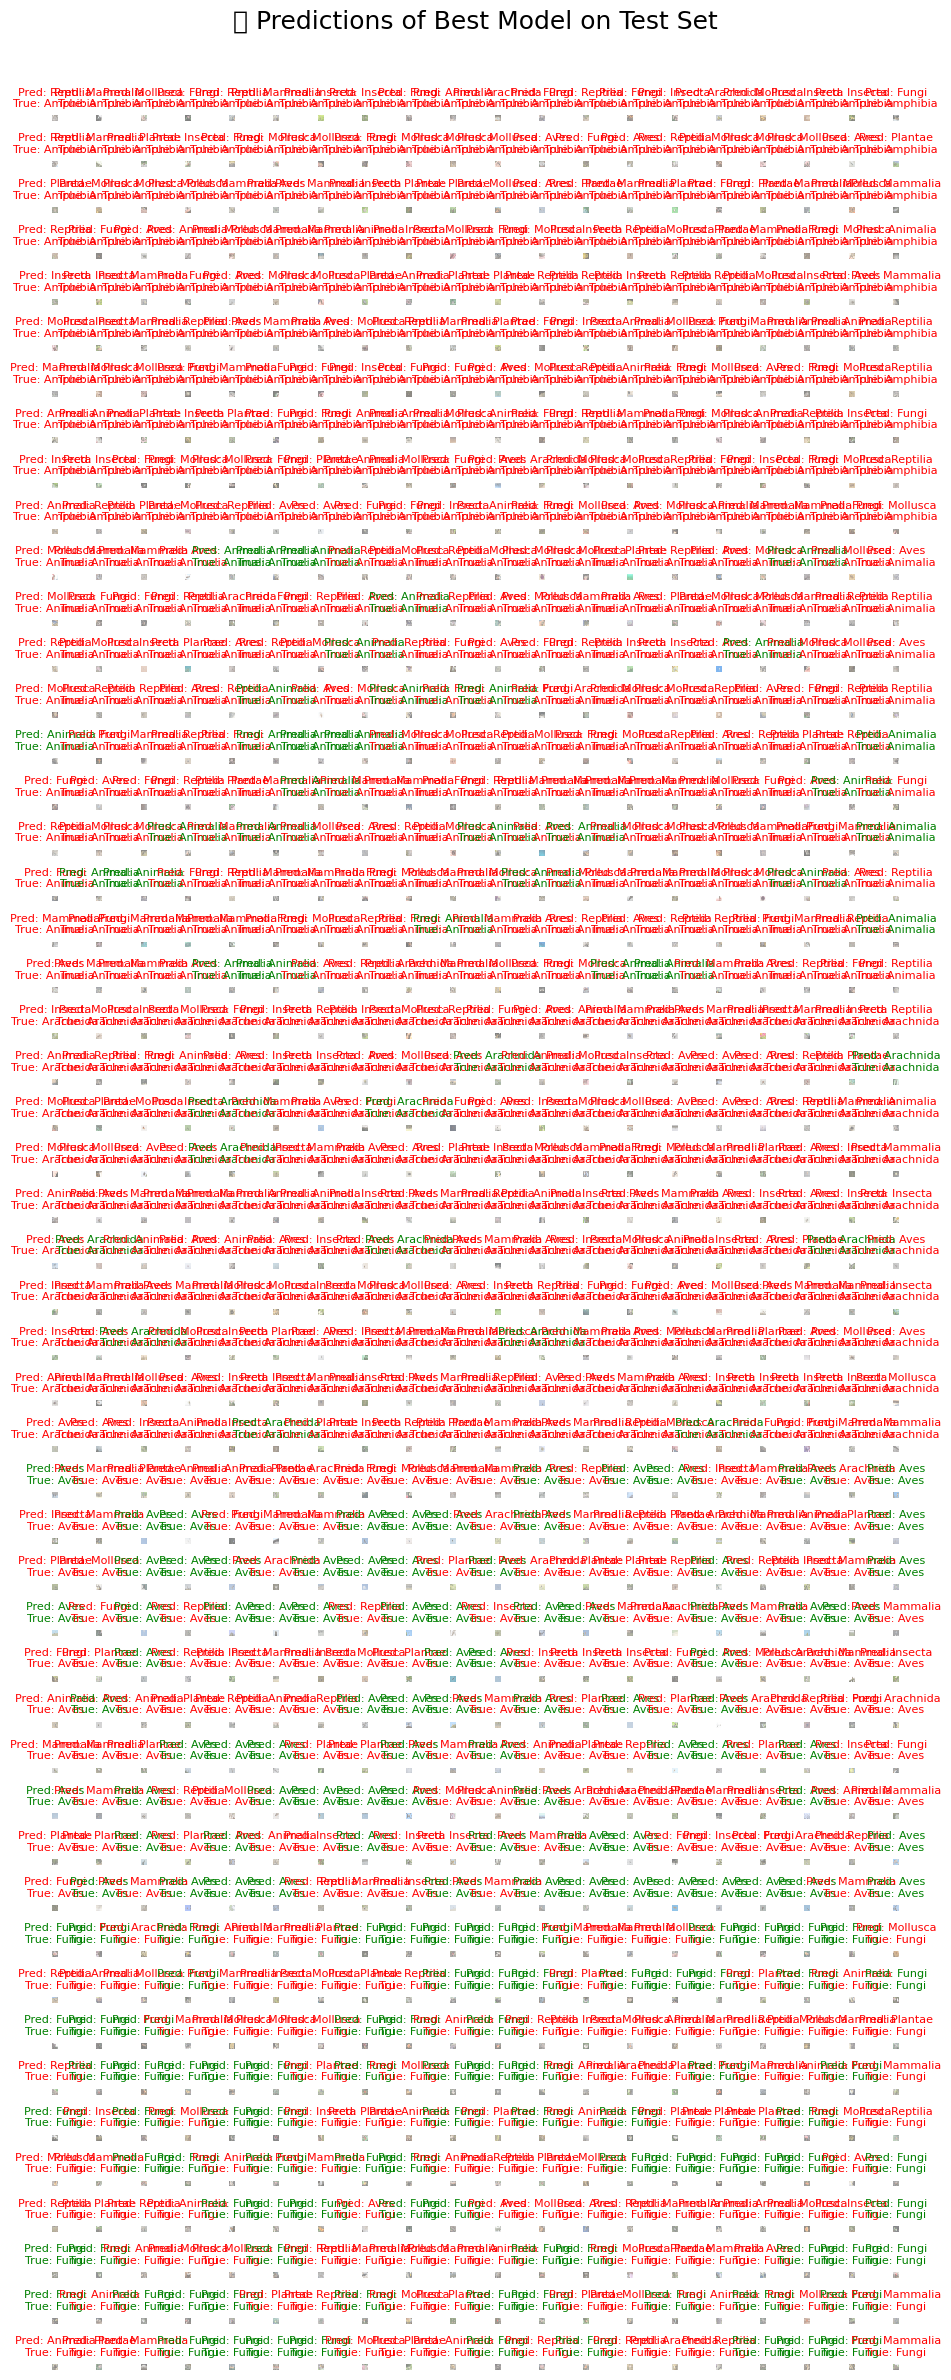

In [41]:

import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.permute(1, 2, 0).cpu().numpy()
    inp = (inp * 0.5) + 0.5  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=8)
    plt.axis('off')

# Gather 30 samples for prediction
samples, predictions = [], []
best_model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        outputs = best_model(images)
        preds = outputs.argmax(1)

        for j in range(images.size(0)):
            samples.append((images[j].cpu(), preds[j].item(), labels[j].item()))
            if len(samples) >= 1000:
                break
        if len(samples) >= 1000:
            break

# Plot 10x3 grid
fig, axes = plt.subplots(50, 20, figsize=(9, 25))
fig.suptitle("🎯 Predictions of Best Model on Test Set", fontsize=18)
for i, ax in enumerate(axes.flat):
    img, pred, true = samples[i]
    color = "green" if pred == true else "red"
    ax.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax.set_title(f"Pred: {classes[pred]}\nTrue: {classes[true]}", fontsize=8, color=color)
    ax.axis("off")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
